In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
from math import log2

In [2]:
def pareto_front(x, y):
    sorted_indices = sorted(range(len(y)), key=lambda k: -y[k])
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    pareto_front_x = [x_sorted[0]]
    pareto_front_y = [y_sorted[0]]

    for i in range(1, len(x_sorted)):
        if x_sorted[i] > pareto_front_x[-1]:
            pareto_front_x.append(x_sorted[i])
            pareto_front_y.append(y_sorted[i])

    return pareto_front_x, pareto_front_y


SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc(
    "axes", labelsize=MEDIUM_SIZE
)  # fontsize of the x and y labels for the small plots
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc(
    "figure", labelsize=BIGGER_SIZE
)  # fontsize of the x and y labels for the big plots

cmap = plt.get_cmap("tab10")
next_unused_cmap_index = 0
cmap_colors = {}

filter_out_map = {
    "sift-128-euclidean": [-16, -15, -14, -13, -12],
    "glove-100-angular": [-16, -15, -14, -13, -12],
    "deep-image-96-angular": [-1, -3, -5, -7, -9, -11, -13, -15, -16],
    "redcaps-512-angular": [-1, -3, -5, -7, -9, -11, -13, -15, -16],
}

/tmp/ipykernel_1927275/305078603.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap("viridis")(log2(int(branching_factor)) / 8)


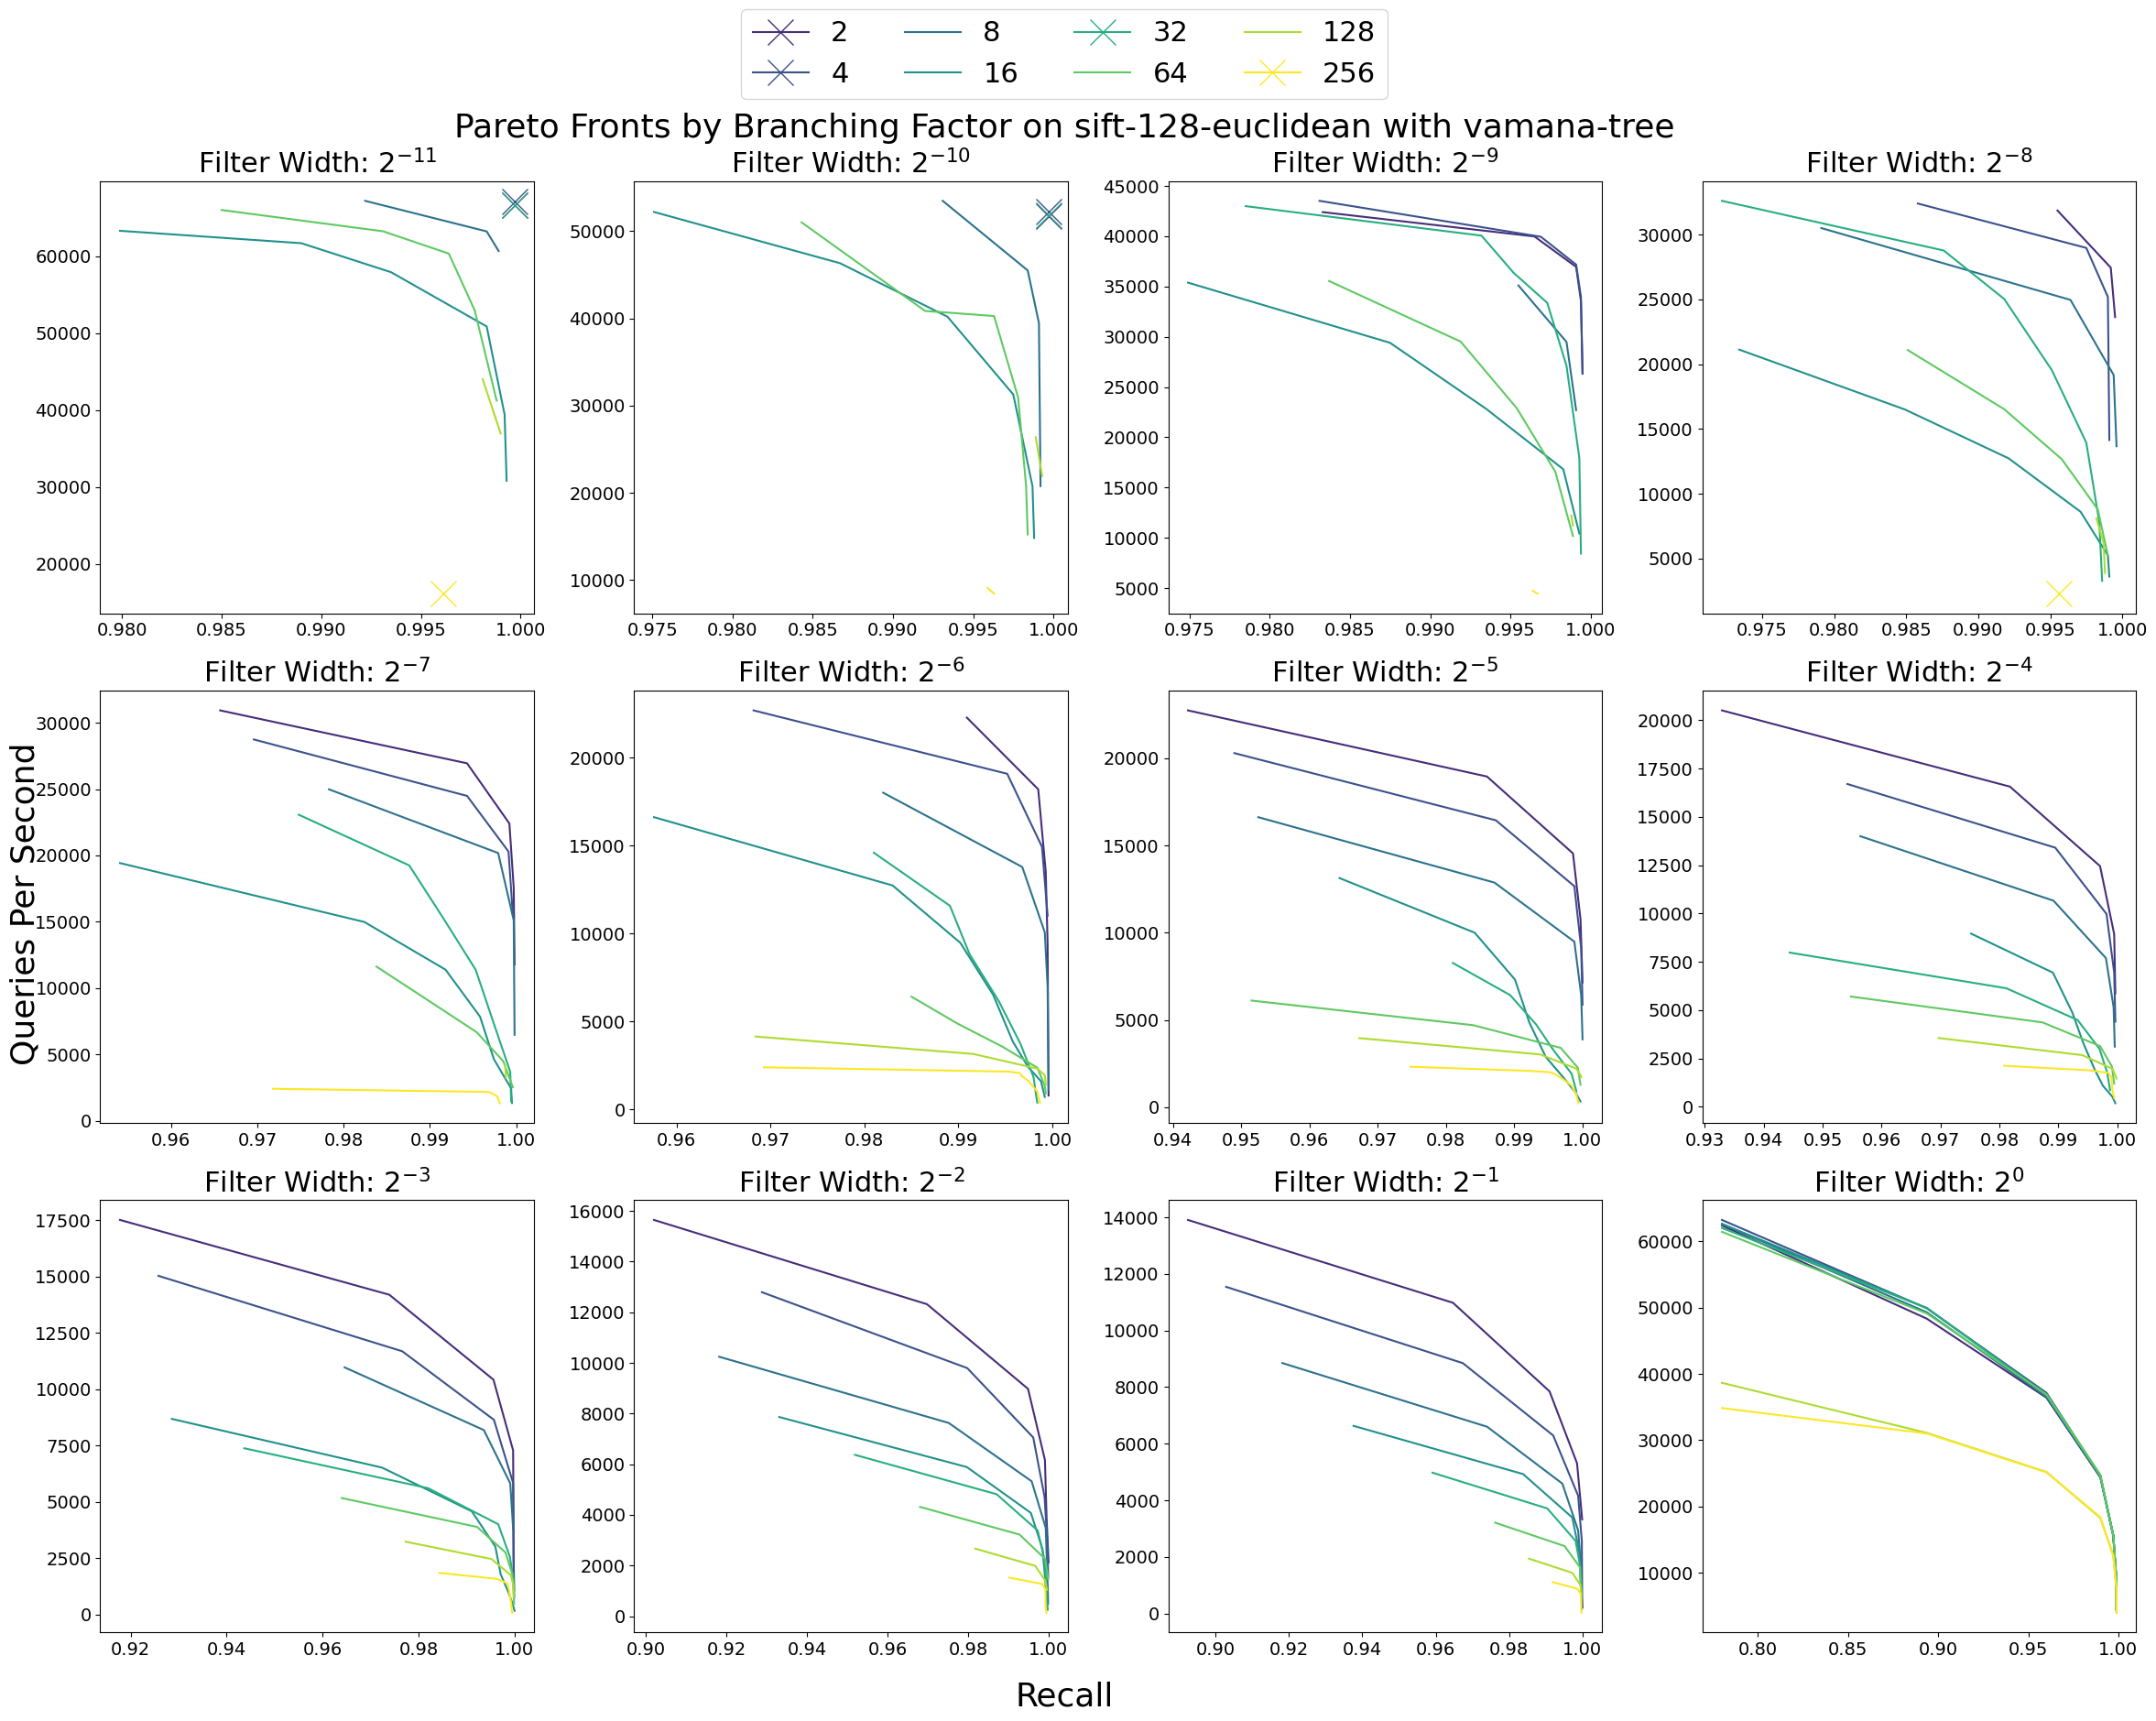

/tmp/ipykernel_1927275/305078603.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap("viridis")(log2(int(branching_factor)) / 8)


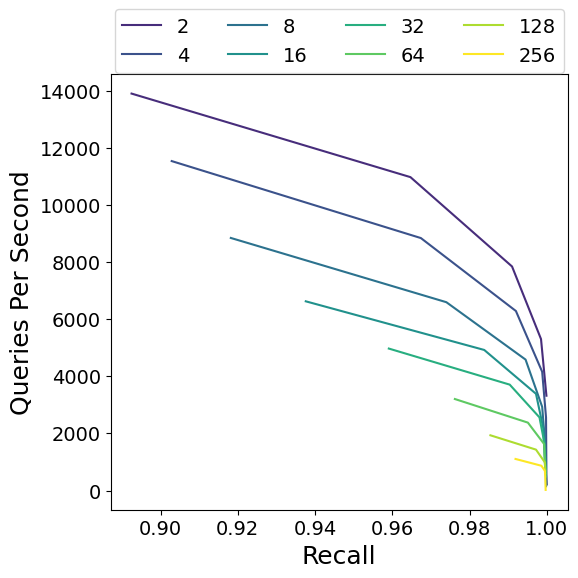

In [14]:
def plot(dataset_name):
    global next_unused_cmap_index

    # Read in all csvs containing dataset_name as a substring
    paths = glob.glob(f"results/*{dataset_name}*.csv")
    dfs = [pd.read_csv(path) for path in paths]
    df = pd.concat(dfs)

    df["filter_width"] = df["filter_width"].str.strip("_")

    filter_out = [f"2pow{i}" for i in filter_out_map[dataset_name]]
    df = df[~df["filter_width"].isin(filter_out)]

    df["method"] = df["method"].str.split("_").str[0]

    # filter out rows where the number of threads is not 16
    df = df[df["threads"] == 16]

    # want a separate plot for each method
    methods_data = df.groupby("method")

    for method, df in methods_data:
        grouped_data = df.groupby(["filter_width", "branching_factor"])

        num_plots = len(df["filter_width"].unique())
        num_cols = 4
        num_rows = (num_plots + num_cols - 1) // num_cols
        plot_scaler = 6

        fig, axes = plt.subplots(
            num_rows,
            num_cols,
            figsize=(plot_scaler * num_cols, plot_scaler * num_rows),
            tight_layout=True,
        )
        axes = axes.reshape(-1)

        for (filter_width, branching_factor), group in grouped_data:
            # if method not in cmap_colors:
            #     cmap_colors[method] = cmap(next_unused_cmap_index)
            #     next_unused_cmap_index += 1
            # color = cmap_colors[method]
            color = plt.cm.get_cmap("viridis")(log2(int(branching_factor)) / 8)
            # print(log2(int(branching_factor)))

            ax = axes[df["filter_width"].unique().tolist().index(filter_width)]
            sorted_group = group.sort_values(by="recall", ascending=False)

            x, y = pareto_front(
                np.array(sorted_group["recall"]),
                1.0 / np.array(sorted_group["average_time"]),
            )

            if len(x) == 1:
                ax.plot(x, y, label=int(branching_factor),
                        markersize=20, marker="x", color=color)
            else:
                ax.plot(x, y, label=int(branching_factor), color=color)

            title = f"Filter Width: {filter_width.replace('2pow', '2^')}"

            # adding formatting so the exponent will render as an exponent
            title = re.sub(r"2\^(-?\d+)", r"$2^{\1}$", title)

            ax.set_title(title)

        fig.supxlabel("Recall")
        fig.supylabel("Queries Per Second")
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center",
                   bbox_to_anchor=(0.5, 0.98), ncol=4)

        fig.suptitle(f"Pareto Fronts by Branching Factor on {dataset_name} with {method}")

        plt.tight_layout()
        plt.savefig(
            f"results/plots/{dataset_name}_branching_results.pdf", bbox_inches="tight")
        plt.show()

        # another plot with the same title but limited to only the 2^-1 branching factor
        fig, ax = plt.subplots(figsize=(plot_scaler, plot_scaler))
        grouped_data = df.groupby(["filter_width", "branching_factor"])
        for (filter_width, branching_factor), group in grouped_data:
            if filter_width != "2pow-1":
                continue

            sorted_group = group.sort_values(by="recall", ascending=False)

            color = plt.cm.get_cmap("viridis")(log2(int(branching_factor)) / 8)

            x, y = pareto_front(
                np.array(sorted_group["recall"]),
                1.0 / np.array(sorted_group["average_time"]),
            )

            if len(x) == 1:
                ax.plot(x, y, label=int(branching_factor),
                        markersize=20, marker="x", color=color)
            else:
                ax.plot(x, y, label=int(branching_factor), color=color)

        # fig.suptitle(f"Pareto Fronts by Branching Factor at Filter Width $2^{'{-1}'}$", size=MEDIUM_SIZE)
        ax.set_xlabel("Recall", size=(SMALL_SIZE + MEDIUM_SIZE) // 2)
        ax.set_ylabel("Queries Per Second", size=(SMALL_SIZE + MEDIUM_SIZE) // 2)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc="lower center",
                   bbox_to_anchor=(0.5, 0.98), ncol=4, fontsize=SMALL_SIZE)
        
        plt.tight_layout()
        plt.savefig(
            f"results/plots/{dataset_name}_branching_results_2pow-1.pdf", bbox_inches="tight")
        plt.show()


        
plot("sift-128-euclidean")

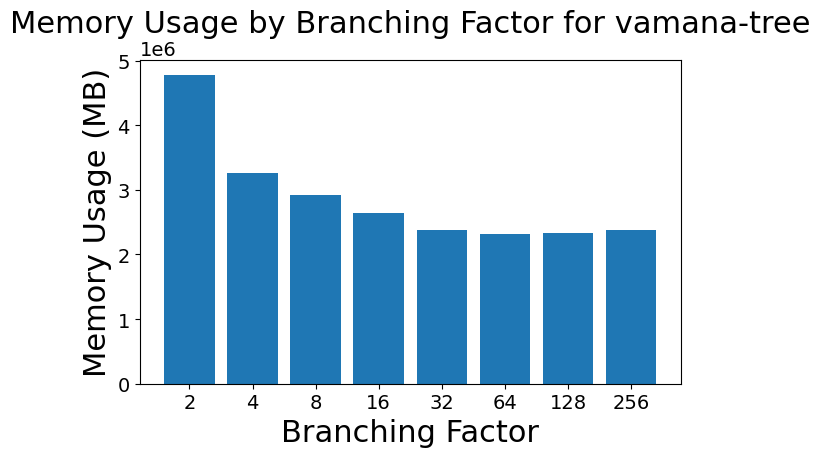

In [4]:
df = pd.read_csv("results/vamana_tree_memory_usage.csv")

# filter out rows where memory is 0
df = df[df["memory"] != 0]

# df["method"] = df["method"].str.split("_").str[0]

# want to restrict to unique method-branching factor pairs
df = df.drop_duplicates(subset=["method", "branching_factor"])

methods_data = df.groupby("method")

# want a separate plot for each method
for method, df in methods_data:
    # bar plot of memory usage by branching factor which should be cast to strings
    df = df.sort_values(by="branching_factor")
    plt.bar(df["branching_factor"].astype(str), df["memory"])
    plt.title(f"Memory Usage by Branching Factor for {method}")
    plt.xlabel("Branching Factor")
    plt.ylabel("Memory Usage (MB)")
    # plt.savefig(f"results/plots/{method}_memory.pdf")
    plt.tight_layout()
    plt.show()

   branching_factor filter_width               method  recall  average_time  \
0                 2        2pow0  super-postfiltering     1.0      0.001690   
1                 4        2pow0  super-postfiltering     1.0      0.001565   
2                 8        2pow0  super-postfiltering     1.0      0.000086   
3                16        2pow0  super-postfiltering     1.0      0.000150   
4                32        2pow0  super-postfiltering     1.0      0.001555   
5                64        2pow0  super-postfiltering     1.0      0.003023   
6               128        2pow0  super-postfiltering     1.0      0.012126   
7               256        2pow0  super-postfiltering     1.0      0.027630   

            qps  threads  build_time   memory  
0  50603.896966       96    2.053469  2771400  
1  42819.119178       96    0.643610        0  
2  45675.654484       96    1.037640        0  
3  50528.912876       96    1.032434        0  
4  41645.689775       96    0.459257        0  


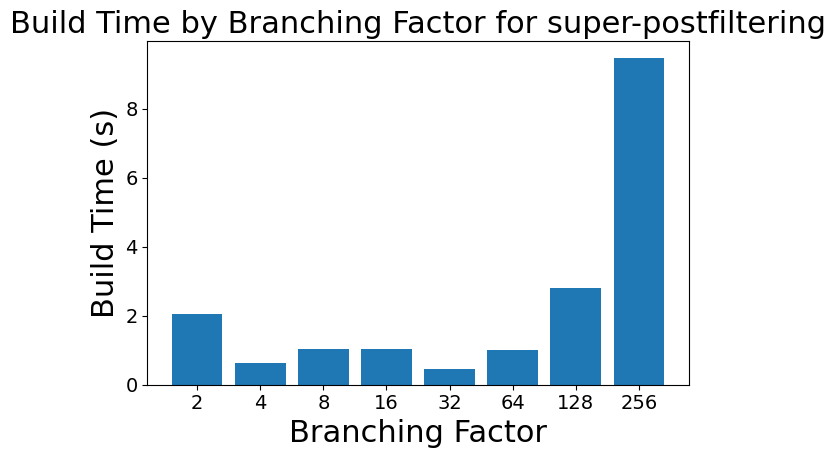

   branching_factor filter_width       method  recall  average_time  \
0                 2        2pow0  vamana-tree  0.9997      0.000055   
1                 4        2pow0  vamana-tree  0.9998      0.000068   
2                 8        2pow0  vamana-tree  0.9998      0.000093   
3                16        2pow0  vamana-tree  0.9998      0.000115   
4                32        2pow0  vamana-tree  0.9998      0.000157   
5                64        2pow0  vamana-tree  0.9999      0.000238   
6               128        2pow0  vamana-tree  0.9997      0.000360   
7               256        2pow0  vamana-tree  0.9997      0.000576   

             qps  threads  build_time   memory  
0  104818.293140       96  202.518780  5061432  
1  104878.575715       96  112.637899        0  
2  105700.561982       96   83.220827   143376  
3  105554.258103       96   66.875733    48092  
4  105943.521091       96   58.911286    19636  
5  107120.521006       96   50.347150     6252  
6  107008.470252 

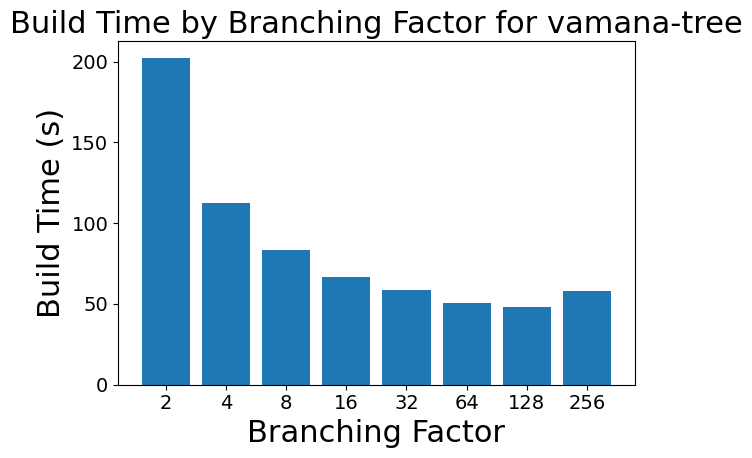

In [5]:
df = pd.read_csv("results/build_memory_sift-128-euclidean_results.csv")

df["method"] = df["method"].str.split("_").str[0]

methods_data = df.groupby("method")

# want a separate plot for each method
for method, df in methods_data:
    df = df.groupby("branching_factor").max()
    df = df.reset_index()
    print(df)
    # bar plot of memory usage by branching factor which should be cast to strings
    df = df.sort_values(by="branching_factor")
    plt.bar(df["branching_factor"].astype(str), df["build_time"])
    plt.title(f"Build Time by Branching Factor for {method}")
    plt.xlabel("Branching Factor")
    plt.ylabel("Build Time (s)")
    # plt.savefig(f"results/plots/{method}_memory.pdf")
    plt.tight_layout()
    plt.show()

In [6]:
def plot_memory_usage(df, ax):
    df = df[df["memory"] != 0]
    df = df.drop_duplicates(subset=["method", "branching_factor"])

    # convert KB to GB
    df["memory"] = df["memory"] / 1000 / 1000
    methods_data = df.groupby("method")

    for method, df_method in methods_data:
        df_method = df_method.sort_values(by="branching_factor")
        ax.bar(df_method["branching_factor"].astype(str), df_method["memory"])

    ax.set_title("Index Size by Branching Factor")
    ax.set_xlabel("Branching Factor")
    ax.set_ylabel("Memory Usage (GB)")
    # ax.legend()

In [7]:
def plot_build_time(df, ax):
    df["method"] = df["method"].str.split("_").str[0]
    methods_data = df.groupby("method")
    

    for method, df_method in methods_data:
        if "vamana" not in method:
            continue
        df_method = df_method.groupby("branching_factor").max()
        df_method = df_method.reset_index()
        df_method = df_method.sort_values(by="branching_factor")
        ax.bar(df_method["branching_factor"].astype(str), df_method["build_time"])

    ax.set_title("Build Time by Branching Factor")
    ax.set_xlabel("Branching Factor")
    ax.set_ylabel("Build Time (s)")
    # ax.legend()

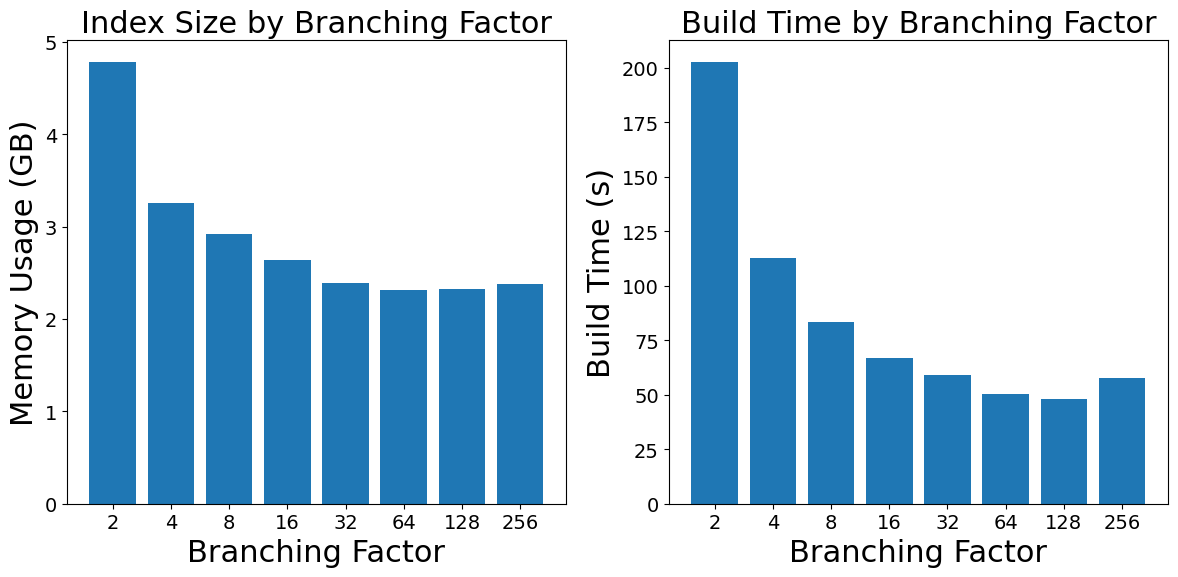

In [8]:
df_memory = pd.read_csv("results/vamana_tree_memory_usage.csv")
df_build = pd.read_csv("results/build_memory_sift-128-euclidean_results.csv")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
plot_memory_usage(df_memory, axs[0])
plot_build_time(df_build, axs[1])

plt.tight_layout()
plt.show()

fig.savefig("results/plots/vamana_memory_build_time.pdf")
